# Knowledge Assembly

In [7]:
from nellinetworkconjunctive import Network
from helpers import fit_sigmoid, mean_squared_error, rotate, load_behavioural_data
from plotting import plotting_init, matrix_plot, mds_plot

import torch
import numpy as np
from scipy.special import expit
from sklearn import manifold
from sklearn.metrics import euclidean_distances

import matplotlib.pyplot as plt
import seaborn as sns

from multiprocessing import Pool

## Load behavioural data

In [8]:
midd_performance, high_performers, low_performers = load_behavioural_data("./behavioural-data/")

## Set simulation mode

In [9]:
mode = "main" # "lazy-regime", "two-readouts", "fixed-inputs"

## Set Hyperparameters

In [ ]:
# Random seeds
seeds_n = 10
mds_seed = 1

# Number of input items
items_n = 7
items_per_context = items_n

# Experiment details
training_blocks = 1 
trials = 2000
training_length = training_blocks * trials

print("Training length:", training_length)

# Network hyperparameters
readouts = 2 if mode == "two-readouts" else 1
h1_size = 20

if mode == "lazy-regime":
    w1_weight_std = np.sqrt(6. / items_n)
    w2_weight_std = np.sqrt(10. / h1_size)
else:
    w1_weight_std = 0.025 * np.sqrt(1 / items_n)
    w2_weight_std = np.sqrt(1 / h1_size)

learning_rate = 0.03 if mode == "lazy-regime" else 0.05

# Parameter space for gridsearch
gammas = np.concatenate([[0], np.geomspace(1e-4, 1, 69)])
ss = np.geomspace(1e-2, 100, 65)

Training length: 16000


## Train Networks

In [19]:
from tqdm import tqdm

def train_networks(gamma):
    # Log
    results = {
        "train": {
            "losses": np.zeros((seeds_n, training_length)),
            "w1s": np.zeros((seeds_n, training_length, h1_size, items_n)),
            "w2s": np.zeros((seeds_n, training_length, readouts, h1_size)),
            "h1s": np.zeros((seeds_n, training_length, items_n, h1_size)),
            "certainties": np.zeros((seeds_n, training_length, items_n, items_n)),
            "evals": np.zeros((seeds_n, items_n, items_n)),
        },
    }
    
    results["train"]["training_progress"] = np.zeros((seeds_n, training_length, items_n, items_n))
    
    for seed in tqdm(range(seeds_n), desc="Seeds"):
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Init Network
        model = Network(items_n, h1_size, w1_weight_std, w2_weight_std, readouts=readouts)
        criterion = torch.nn.MSELoss()
        optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

        training_step = 0
        items_per_context = items_n

        # tqdm for training steps inside the seed
        total_steps = training_blocks * trials
        with tqdm(total=total_steps, desc=f"Seed {seed+1}/{seeds_n}", leave=False) as pbar:
            for block in range(training_blocks):
                items_per_context = 7
                training_pairs = np.asarray(list(zip(range(0, items_per_context - 1), range(1, items_per_context))))
                for trial in range(trials):
                    # Sample input and target
                    random_index = np.random.randint(0, len(training_pairs))
                    item_1, item_2 = np.random.choice(training_pairs[random_index], 2, False)
                    if readouts == 1:
                        target = torch.tensor([1. if item_1 > item_2 else -1.])
                    elif readouts == 2:
                        target = torch.tensor([1., -1.] if item_1 > item_2 else [-1., 1.])

                    # Forward propagate and backpropagate
                    optimiser.zero_grad()
                    _, output = model(item_1, item_2)
                    model.loss = criterion(output, target)
                    model.loss.backward()
                    model.correct(learning_rate, gamma)
                    optimiser.step()

                    # Log
                    with torch.no_grad():
                        results["train"]["losses"][seed, training_step] = model.loss.item()
                        results["train"]["w1s"][seed, training_step] = model.layer_1.weight.detach().numpy().copy()
                        results["train"]["w2s"][seed, training_step] = model.layer_2.weight.detach().numpy().copy()
                        results["train"]["h1s"][seed, training_step] = model.extract_h1s()
                        results["train"]["certainties"][seed, training_step] = model.pairwise_certainty.a.copy()
                        results["train"]["training_progress"][seed, training_step] = model.evaluate()
                    
                    training_step += 1
                    pbar.update(1)
        
        # Evaluate
        with torch.no_grad():
            results["train"]["evals"][seed] = model.evaluate()
        
    return gamma, results



In [20]:
results = train_networks(.1)

# Plot

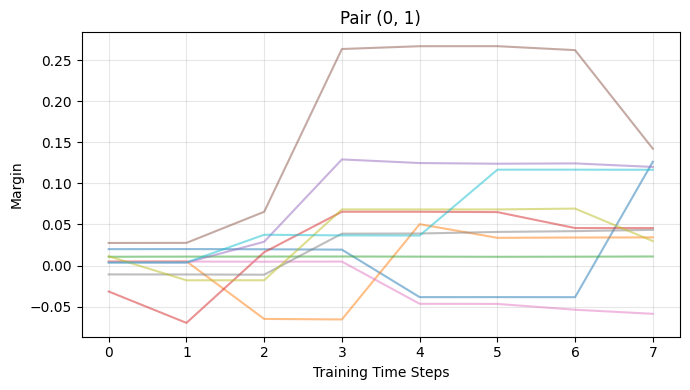

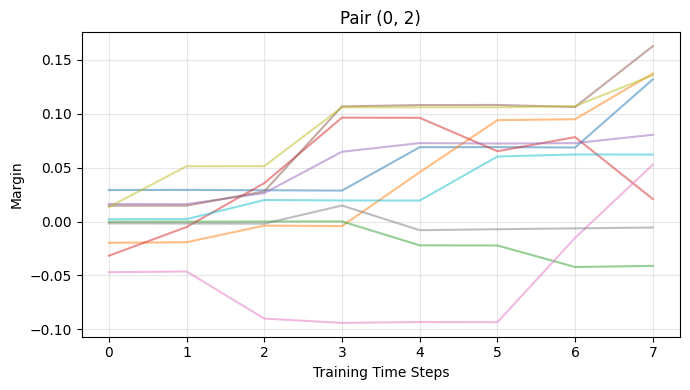

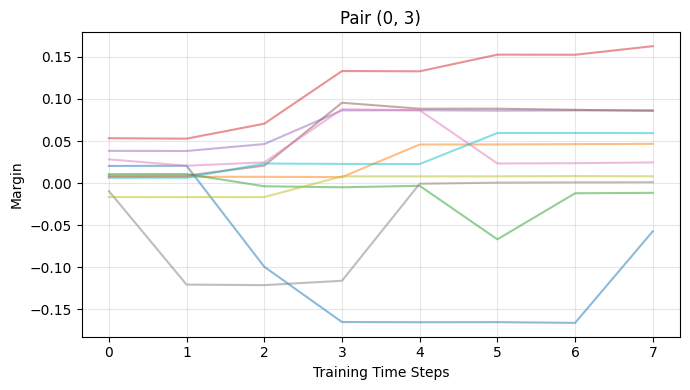

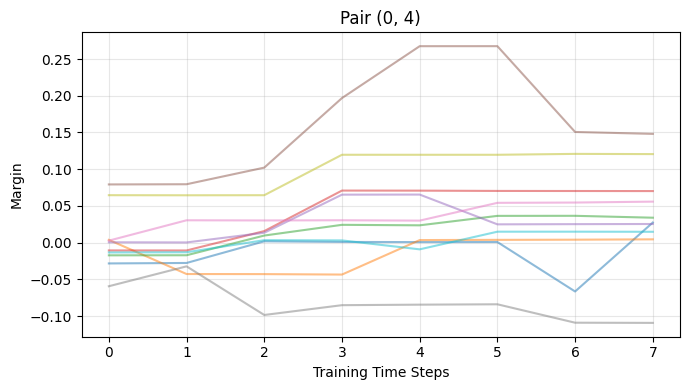

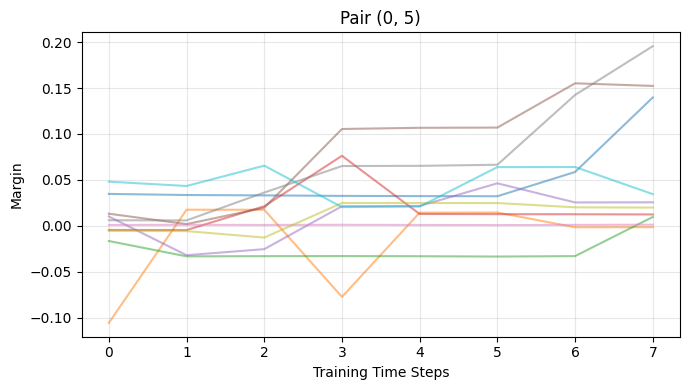

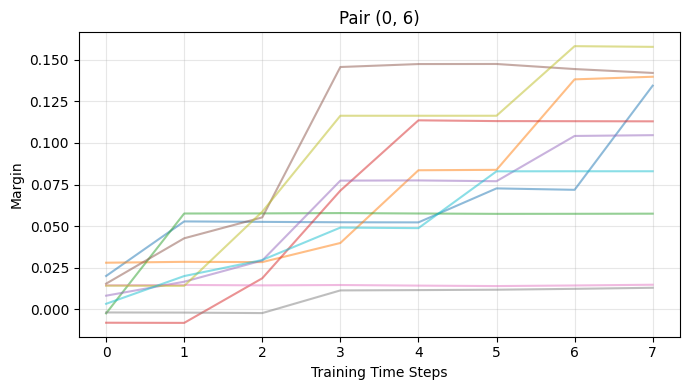

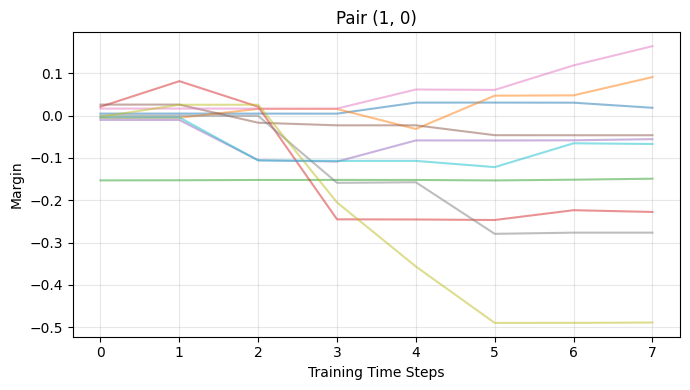

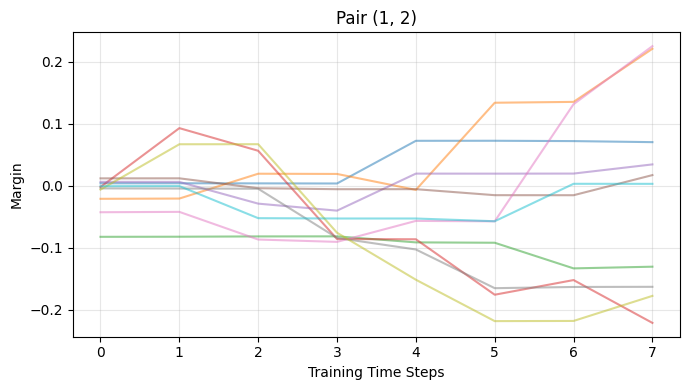

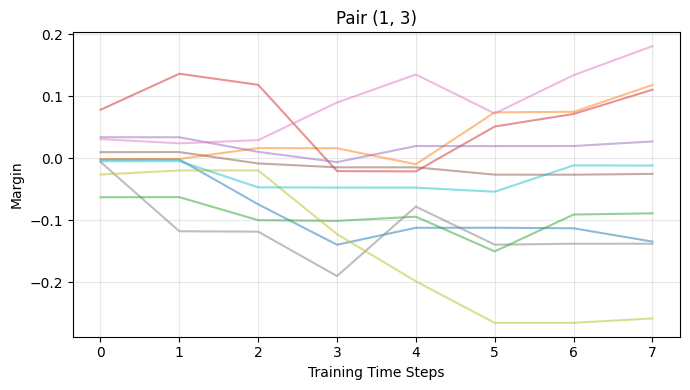

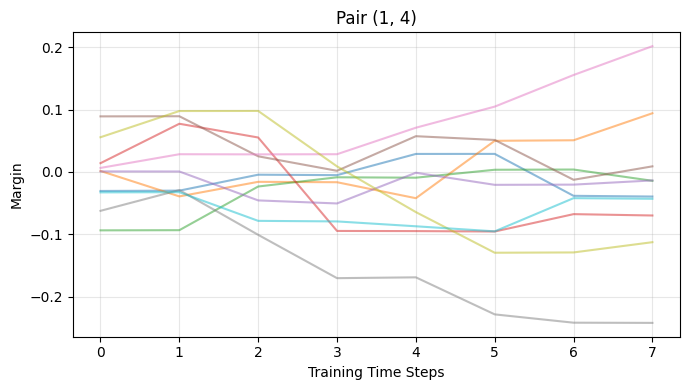

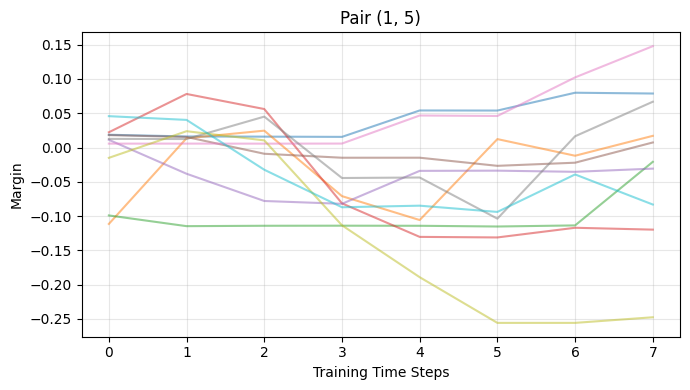

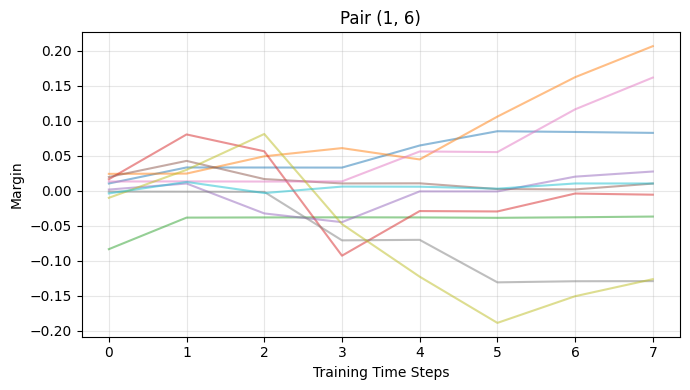

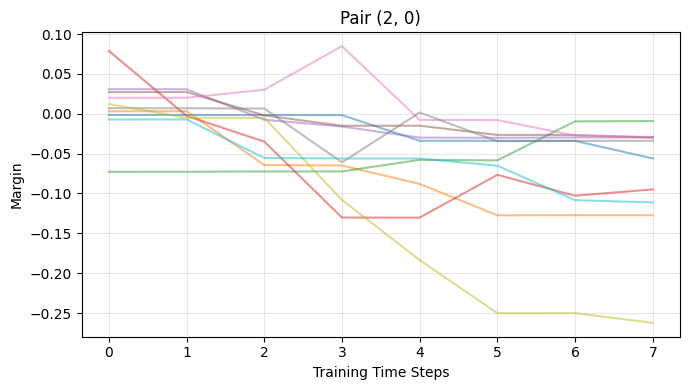

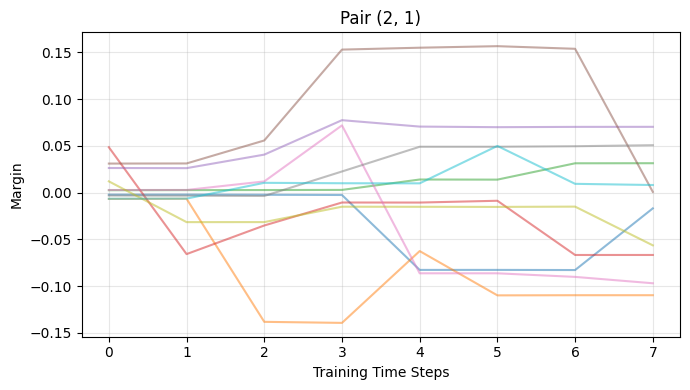

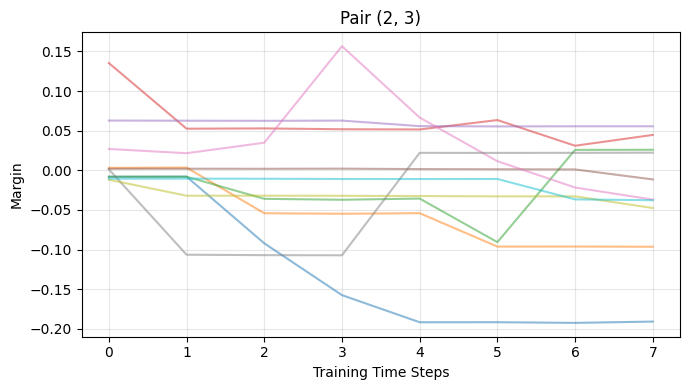

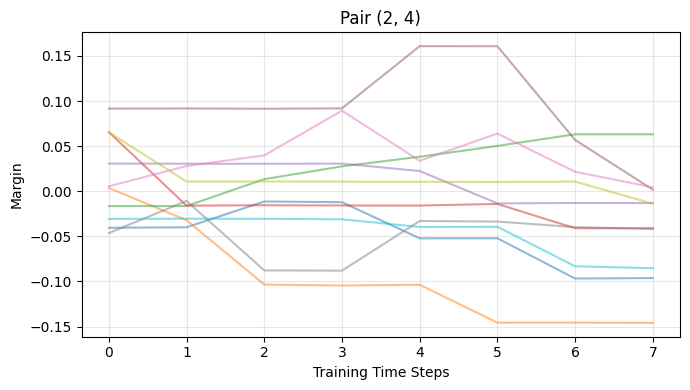

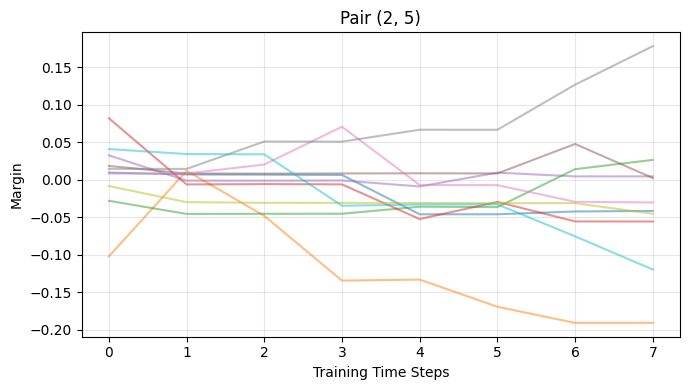

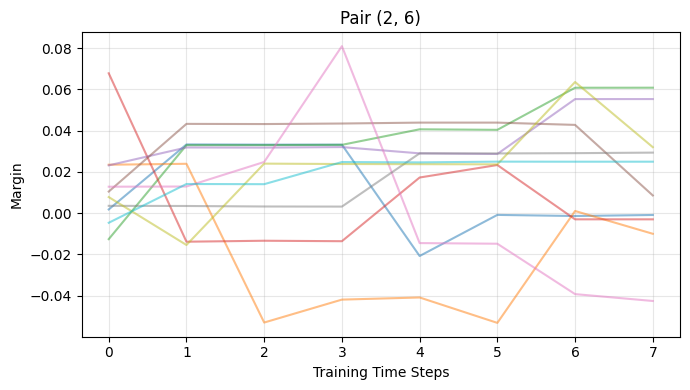

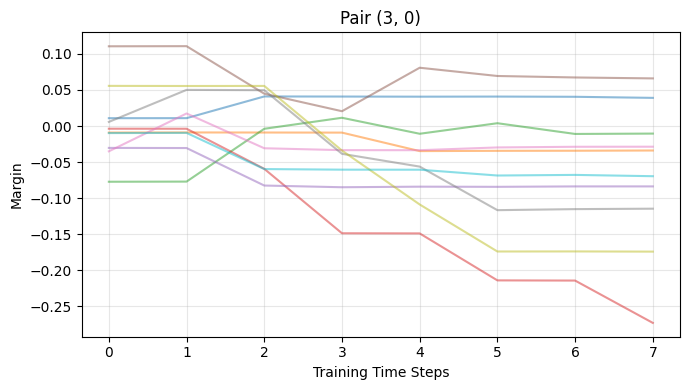

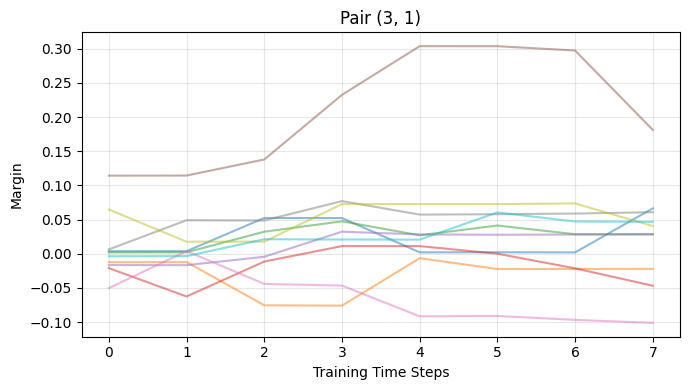

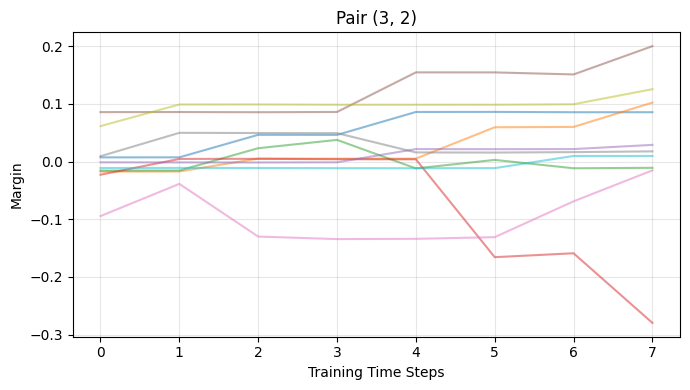

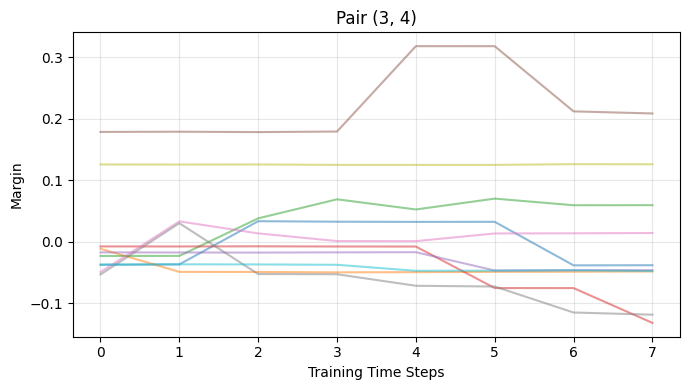

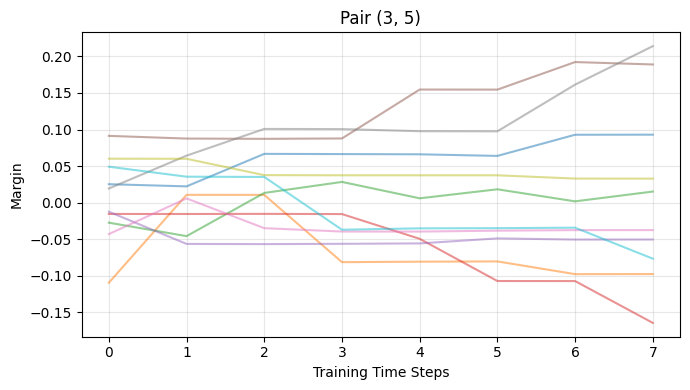

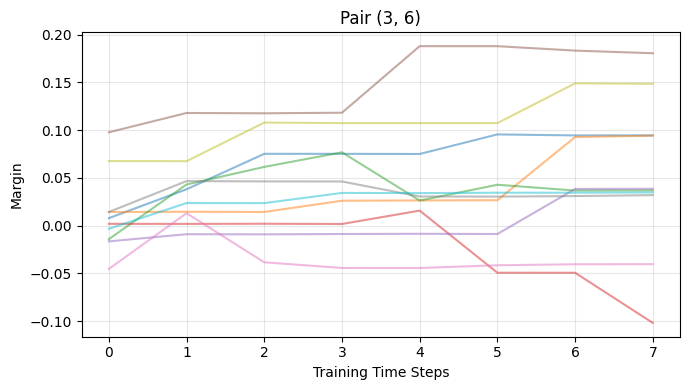

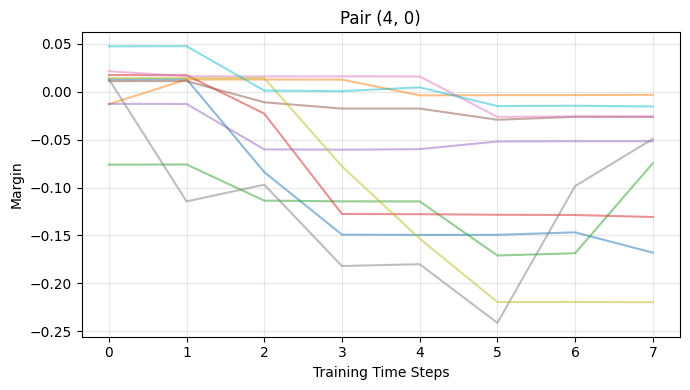

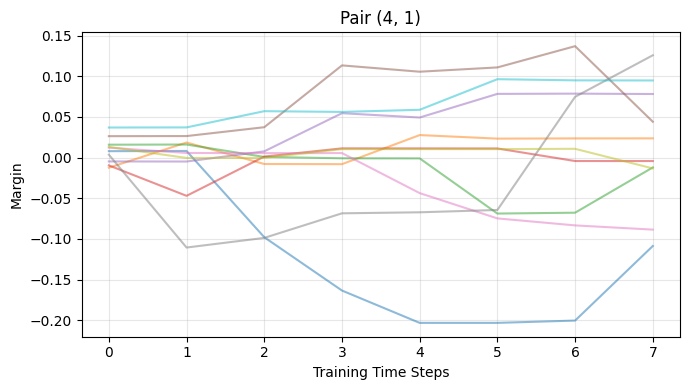

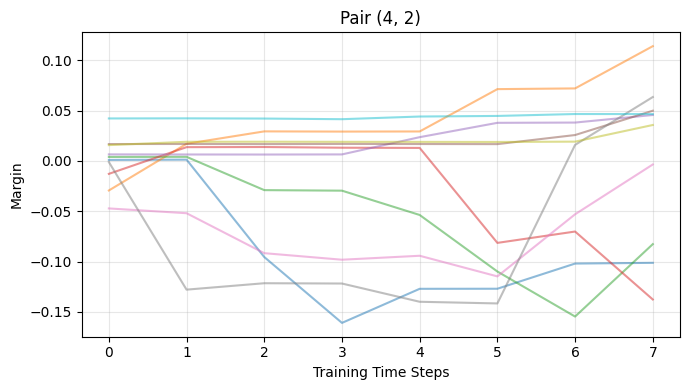

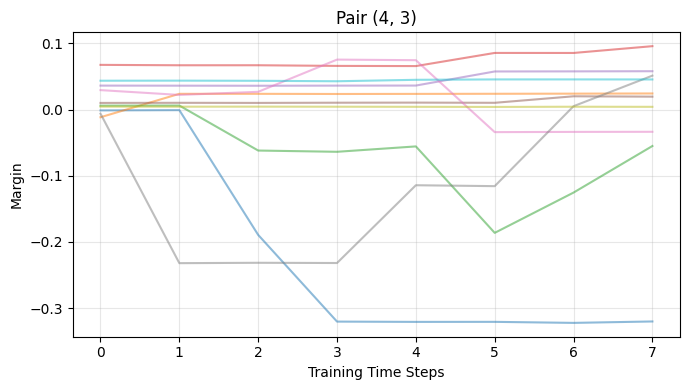

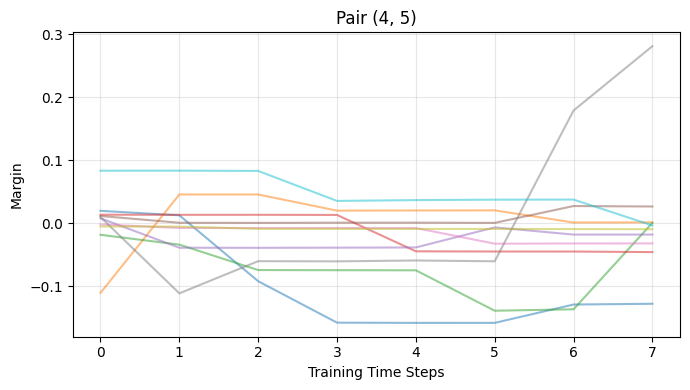

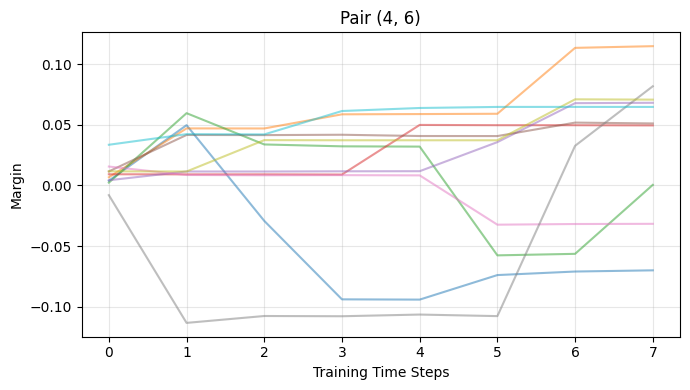

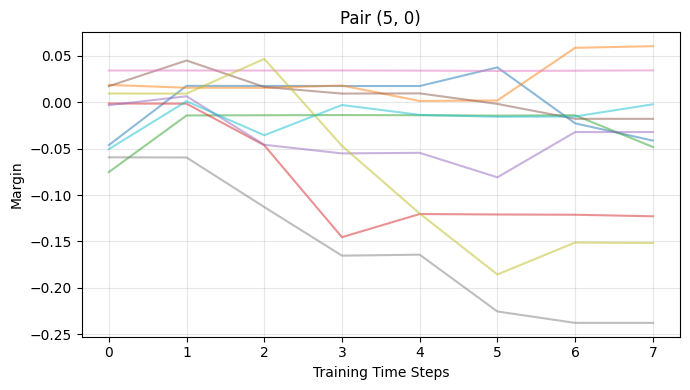

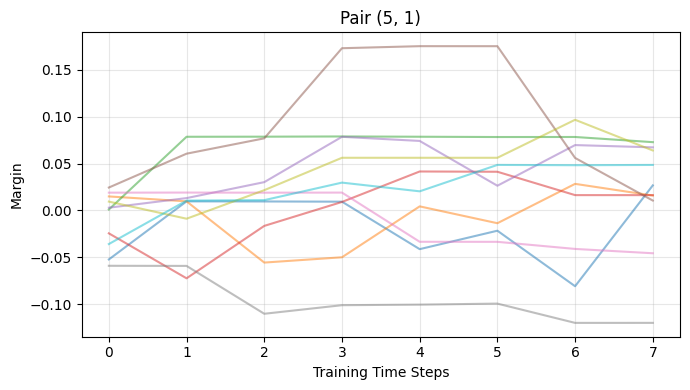

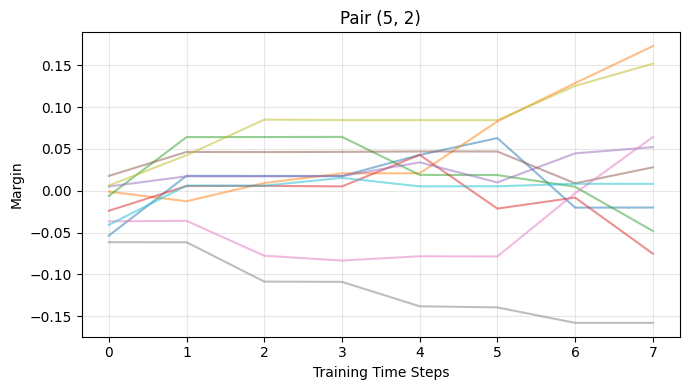

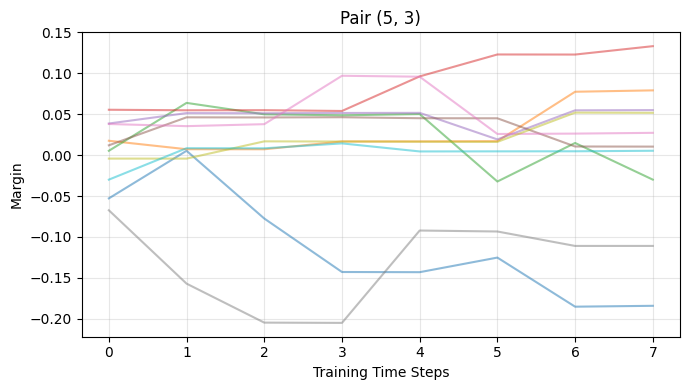

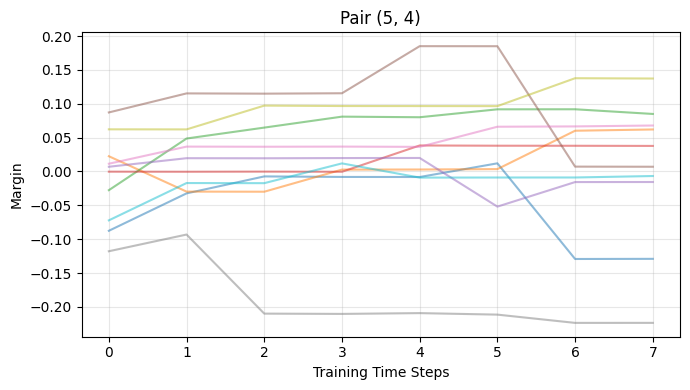

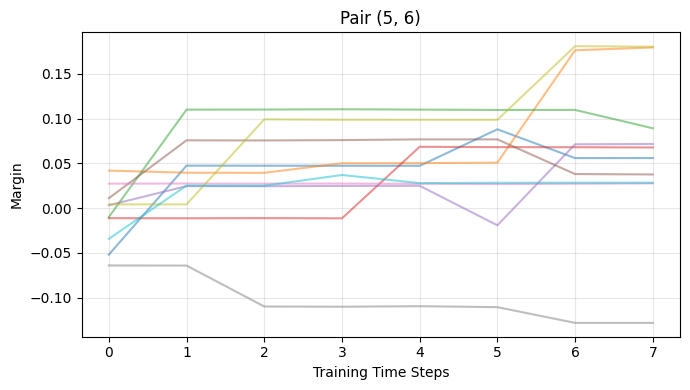

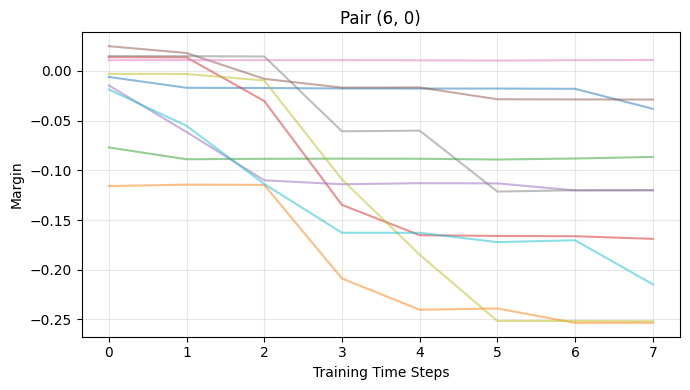

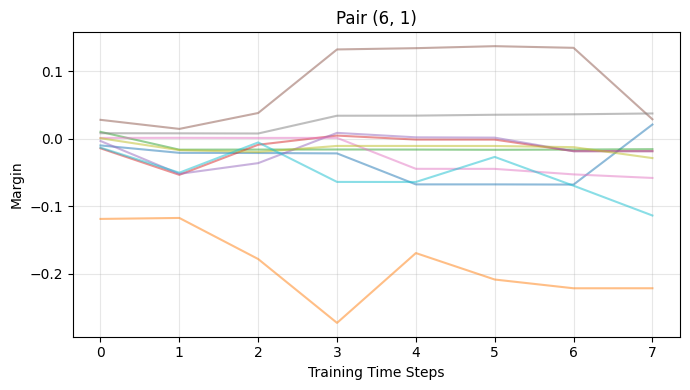

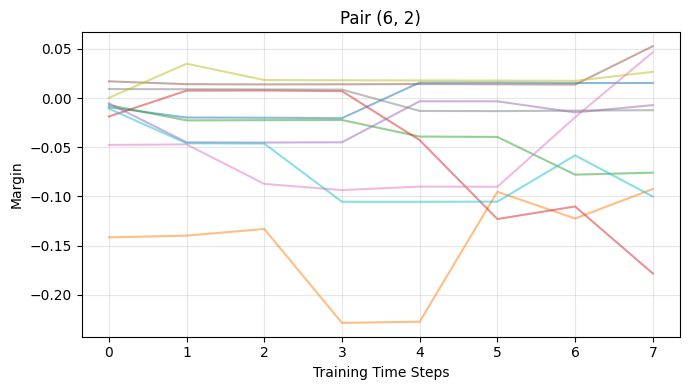

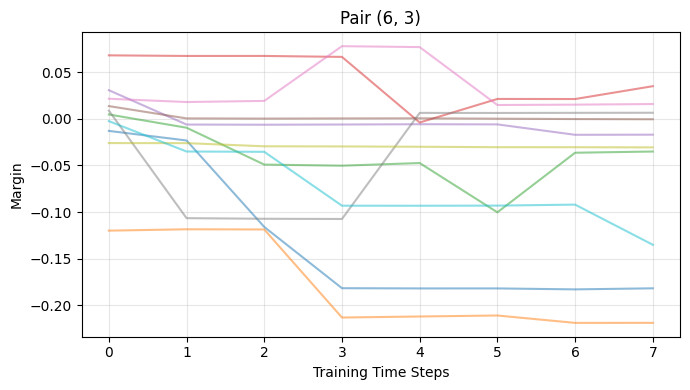

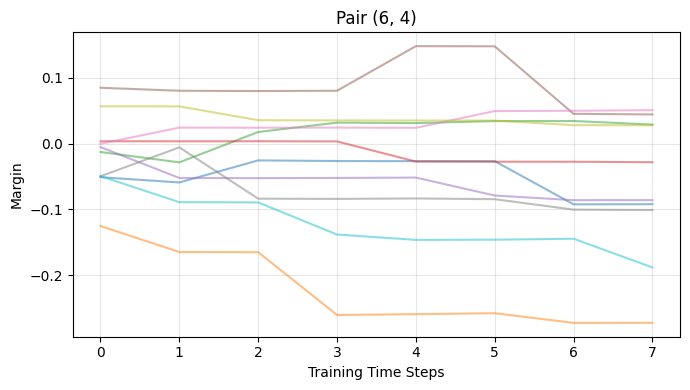

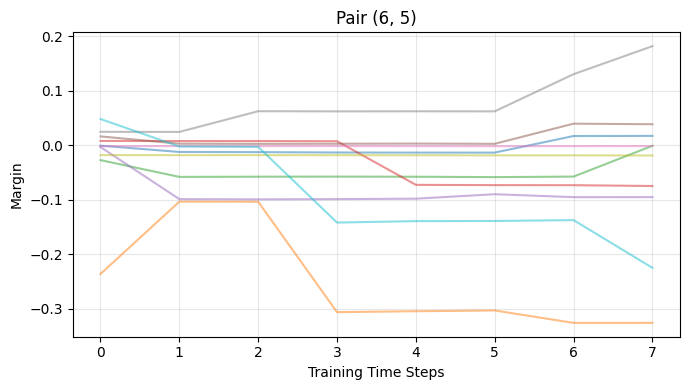

In [ ]:
# Plot for every possible pair (i, j) in different figures
# If results is a tuple, unpack it to get the actual results dict
if isinstance(results, tuple):
    results = results[1]
training_progress = results["train"]["training_progress"]
seeds_n = training_progress.shape[0]
items_n = training_progress.shape[2]

for i in range(items_n):
    for j in range(items_n):
        if i == j:
            continue  # skip diagonal if desired
        plt.figure(figsize=(7,4))
        for seed in range(seeds_n):
            plt.plot(training_progress[seed, :480, i, j], alpha=0.5)
        plt.xlabel("Training Time Steps")
        plt.ylabel("Margin")
        plt.title(f"Pair ({i}, {j})")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [ ]:
from csv_margin import MarginExtractor

# Use MarginExtractor to save training margins to CSV
# If results is a tuple, unpack it to get the actual results dict
if isinstance(results, tuple):
    results = results[1]

extractor = MarginExtractor(results)
csv_filename = "conjuntive_rich_TI_margins.csv"
extractor.write_csv(csv_filename)
print(f"Margins saved to {csv_filename}")

# Plot the margins over every training step for (i=1, j=2)
import matplotlib.pyplot as plt
import numpy as np


NameError: name 'results' is not defined

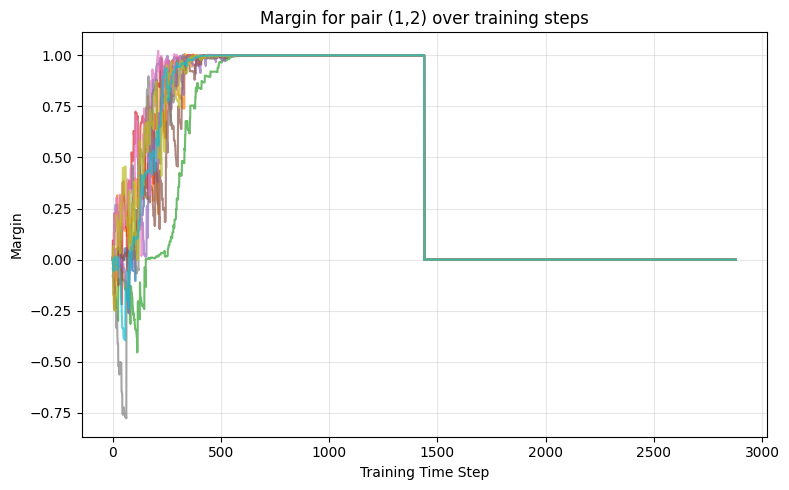

In [ ]:

# If results is a tuple, unpack it to get the actual results dict
import pandas as pd

csv_filename = "conjuntive_rich_TI_margins.csv"
df = pd.read_csv(csv_filename)

# Select (i=1, j=2)
i, j = 1, 2
df_pair = df[(df["i"] == i) & (df["j"] == j)]
if df_pair.empty:
    raise ValueError(f"No data found for pair (i={i}, j={j}) in the CSV.")

seed_cols = [col for col in df.columns if col.startswith("seed_")]
seeds_n = len(seed_cols)
time_steps = df_pair.shape[0]

plt.figure(figsize=(8,5))
for seed_idx, seed_col in enumerate(seed_cols):
    plt.plot(
        df_pair["time_step"],
        df_pair[seed_col],
        label=f"seed {seed_idx}" if seeds_n <= 5 else None,
        alpha=0.7,
    )

plt.xlabel("Training Time Step")
plt.ylabel("Margin")
plt.title("Margin for pair (1,2) over training steps")
plt.grid(True, alpha=0.3)
plt.tight_layout()
if seeds_n <= 5:
    plt.legend()
plt.show()



Margins for each (i, j) at time_step=2879, for each seed:
Pair (i=0, j=0): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=0, j=1): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=0, j=2): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=0, j=3): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=0, j=4): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=0, j=5): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=0, j=6): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=1, j=0): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=1, j=1): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=1, j=2): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=1, j=3): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=1, j=4): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=1, j=5): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=1, j=6): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=2, j=0): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=2, j=1): margins=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pair (i=2, j=2): margins=[0. 0

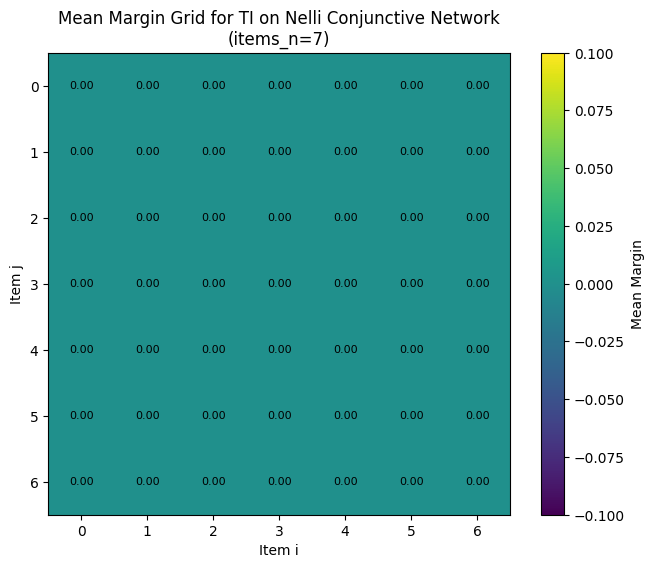

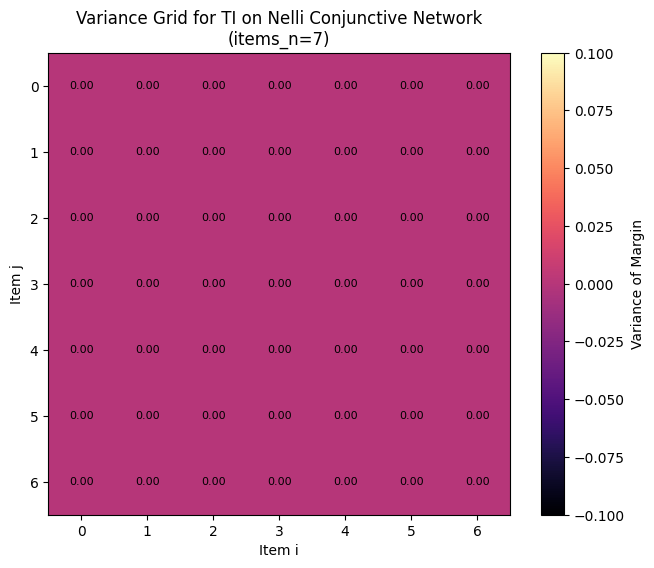

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from csv_margin import MarginExtractor

csv_filename = "conjuntive_rich_TI_margins.csv"

# Load margin grid from the CSV for a specific time_step and plot all pairs (i, j)
time_step = training_length-1  # or set to desired time step to plot
margin_grid, var_grid = MarginExtractor.load_margin_grid_ti_from_csv(csv_filename, time_step)

# Print the margin for each training pair (i, j) at the last time step from margin_grid
last_time_step = time_step  # already set to training_length - 1 before above
print(f"Margins for each (i, j) at time_step={last_time_step}, for each seed:")
for i in range(margin_grid.shape[0]):
    for j in range(margin_grid.shape[1]):
        margins = margin_grid[i, j, :]  # margins for all seeds
        print(f"Pair (i={i}, j={j}): margins={margins}")


items_n = margin_grid.shape[0]
seeds_n = margin_grid.shape[2]

# Plot mean margin grid and variance grid using @file_context_0 style

import matplotlib.pyplot as plt
import numpy as np

Average_Grid = np.mean(margin_grid, axis=2)
Std_Grid = np.var(margin_grid, axis=2)

Display_Grid = Average_Grid.copy()

plt.figure(figsize=(8, 6))
plt.imshow(Display_Grid, cmap='viridis', interpolation='none')
plt.colorbar(label='Mean Margin')
plt.title(f'Mean Margin Grid for TI on Nelli Conjunctive Network\n(items_n={items_n})')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(items_n))
plt.yticks(range(items_n))
for i in range(items_n):
    for j in range(items_n):
        plt.text(j, i, f"{Display_Grid[i, j]:.2f}", ha='center', va='center',
                 color='white' if Display_Grid[i, j] < (Display_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(Std_Grid, cmap='magma', interpolation='none')
plt.colorbar(label='Variance of Margin')
plt.title(f'Variance Grid for TI on Nelli Conjunctive Network\n(items_n={items_n})')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(items_n))
plt.yticks(range(items_n))
for i in range(items_n):
    for j in range(items_n):
        plt.text(j, i, f"{Std_Grid[i, j]:.2f}", ha='center', va='center',
                 color='white' if Std_Grid[i, j] < (Std_Grid.max() / 2) else 'black', fontsize=8)
plt.show()


In [ ]:
def extract_margin_grid_from_csv(csv_filename, time_step=None):
    """
    Loads a CSV file written in the format by MarginExtractor and reconstructs a grid of margin values.

    Args:
        csv_filename (str): Path to the CSV file.
        time_step (int or None): If specified, only extract margins at this time step.
                                 If None, returns a 4D numpy array (timesteps, items_n, items_n, seeds_n).

    Returns:
        If time_step is not None:
            margins_grid: np.ndarray of shape (items_n, items_n, seeds_n)
        Else:
            margins_grid: np.ndarray of shape (num_time_steps, items_n, items_n, seeds_n)
        Also returns: (list of seed columns used)
    """
    import pandas as pd
    import numpy as np

    df = pd.read_csv(csv_filename)
    # Extract seed columns
    seed_cols = [col for col in df.columns if col.startswith("seed_")]
    seeds_n = len(seed_cols)
    items_n = df["i"].max() + 1
    num_time_steps = df["time_step"].max() + 1

    if time_step is not None:
        df_t = df[df["time_step"] == time_step]
        # Sanity: shape should be (items_n * items_n, ...)
        grid = np.empty((items_n, items_n, seeds_n))
        for _, row in df_t.iterrows():
            i, j = int(row["i"]), int(row["j"])
            for s, col in enumerate(seed_cols):
                grid[i, j, s] = row[col]
        return grid, seed_cols
    else:
        # construct (num_time_steps, items_n, items_n, seeds_n)
        grid = np.empty((num_time_steps, items_n, items_n, seeds_n))
        for _, row in df.iterrows():
            t = int(row["time_step"])
            i = int(row["i"])
            j = int(row["j"])
            for s, col in enumerate(seed_cols):
                grid[t, i, j, s] = row[col]
        return grid, seed_cols


In [ ]:
import csv

# Extract training pair results and save to CSV
# We'll save the average margin over seeds for each pair (i, j) at each time step

# If results is a tuple, unpack it to get the actual results dict
if isinstance(results, tuple):
    results = results[1]
training_progress = results["train"]["training_progress"]  # shape: (seeds_n, time_steps, items_n, items_n)
seeds_n, time_steps, items_n, _ = training_progress.shape

# Prepare CSV header
header = ["time_step", "i", "j"] + [f"seed_{seed}" for seed in range(seeds_n)] + ["mean_margin", "std_margin"]

rows = []
for i in range(items_n):
    for j in range(items_n):
        for t in range(time_steps):
            margins = training_progress[:, t, i, j]
            mean_margin = margins.mean()
            std_margin = margins.std()
            row = [t, i, j] + list(margins) + [mean_margin, std_margin]
            rows.append(row)
            
ipynb_filename = "conjuntive_rich_TI.ipynb"

# Write to CSV
# 'network' here refers to a variable defined earlier in the notebook, not to the class 'nellinetwork'.
csv_filename = f"{ipynb_filename}.csv"
with open(csv_filename, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(rows)

print(f"Training pair results saved to {csv_filename}")

Training pair results saved to conjuntive_rich_TI.ipynb.csv


In [ ]:
training_length = 2880

import pandas as pd

# Read the CSV file with training pair margins
df = pd.read_csv(csv_filename)

# Display the first few rows to verify extraction
print("Extracted results from CSV:")
print(df.head())

# Now 'df' contains the extracted results and can be used for further analysis or plotting


Extracted results from CSV:
   time_step  i  j    seed_0    seed_1    seed_2    seed_3    seed_4  \
0          0  0  0  0.018792 -0.000755 -0.042241  0.007779 -0.007472   
1          1  0  0  0.018861 -0.000661 -0.042107  0.007718 -0.007589   
2          2  0  0  0.018710 -0.000712 -0.042191  0.015606 -0.038616   
3          3  0  0  0.018511 -0.000763 -0.042322  0.006729 -0.024446   
4          4  0  0  0.018505  0.009914 -0.074872  0.006729 -0.024226   

     seed_5    seed_6    seed_7    seed_8    seed_9  mean_margin  std_margin  
0  0.010505  0.023729 -0.001627  0.002027  0.008210     0.001895    0.017222  
1  0.010568  0.023774 -0.001668  0.002006  0.008155     0.001905    0.017205  
2  0.010608  0.023695 -0.001715  0.002047  0.008343    -0.000423    0.021481  
3  0.010687  0.023736 -0.001867 -0.067648  0.008446    -0.006894    0.027624  
4  0.010525  0.023543 -0.001996 -0.124378  0.008303    -0.014795    0.045495  


In [ ]:
import numpy as np

print("Columns in DataFrame:", df.columns.tolist())

# Try to find the correct time, i, j column names
# The original code expects 't', but the CSV uses 'time_step'
# Let's map accordingly
col_map = {}
for col in df.columns:
    if col.lower() in ['t', 'time', 'time_step']:
        col_map['t'] = col
    if col.lower() == 'i':
        col_map['i'] = col
    if col.lower() == 'j':
        col_map['j'] = col

# Use mapped column names
t_col = col_map.get('t', 'time_step')
i_col = col_map.get('i', 'i')
j_col = col_map.get('j', 'j')

df_sorted = df.sort_values([t_col, i_col, j_col]).reset_index(drop=True)

# The number of margin columns is seeds_n
margin_cols = [col for col in df.columns if col not in [t_col, i_col, j_col, 'mean_margin', 'std_margin']]
seeds_n = len(margin_cols)
time_steps = df[t_col].max() + 1  # assumes t is 0-based and contiguous
items_n = max(df[i_col].max(), df[j_col].max()) + 1  # assuming 0-based indexing

# Initialize training_progress array
training_progress = np.zeros((seeds_n, time_steps, items_n, items_n))

# Fill the array
for idx, row in df.iterrows():
    t = int(row[t_col])
    i = int(row[i_col])
    j = int(row[j_col])
    for s, col in enumerate(margin_cols):
        training_progress[s, t, i, j] = row[col]

Columns in DataFrame: ['time_step', 'i', 'j', 'seed_0', 'seed_1', 'seed_2', 'seed_3', 'seed_4', 'seed_5', 'seed_6', 'seed_7', 'seed_8', 'seed_9', 'mean_margin', 'std_margin']


# Unflip These

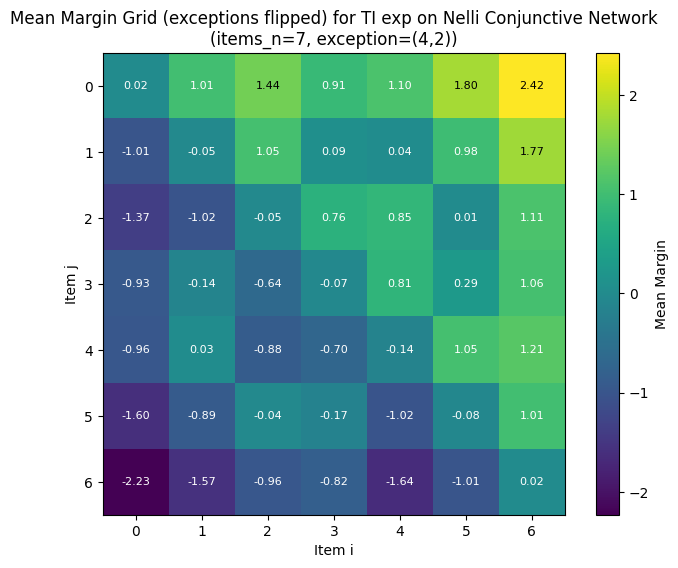

In [ ]:
import matplotlib.pyplot as plt

items_per_context = 7
n = items_n

Grid = np.zeros((seeds_n, n, n))
for seed in range(seeds_n):
    for i in range(n):
        for j in range(n):
            Grid[seed, i, j] = training_progress[seed, 480, i, j]
Average_Grid = np.mean(Grid, axis=0)
Std_Grid = np.var(Grid, axis=0)

# For the normal TI case, do not flip exception cells
Display_Grid = Average_Grid.copy()

plt.figure(figsize=(8, 6))
plt.imshow(Display_Grid, cmap='viridis', interpolation='none')
plt.colorbar(label='Mean Margin')
plt.title(f'Mean Margin Grid for TI on Nelli Conjunctive Network\n(items_n={items_n})')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot mean numbers over each square, using Display_Grid for values
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Display_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Display_Grid[i, j] < (Display_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(Std_Grid, cmap='magma', interpolation='none')
plt.colorbar(label='Variance of Margin')
plt.title(f'Variance Grid for TI on Nelli Conjunctive Network\n(items_n={items_n})')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot variance numbers over each square, using Std_Grid for values
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Std_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Std_Grid[i, j] < (Std_Grid.max() / 2) else 'black', fontsize=8)
plt.show()


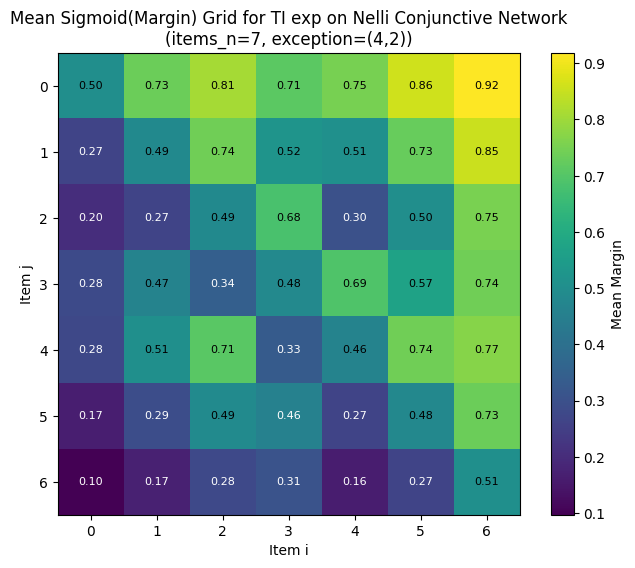

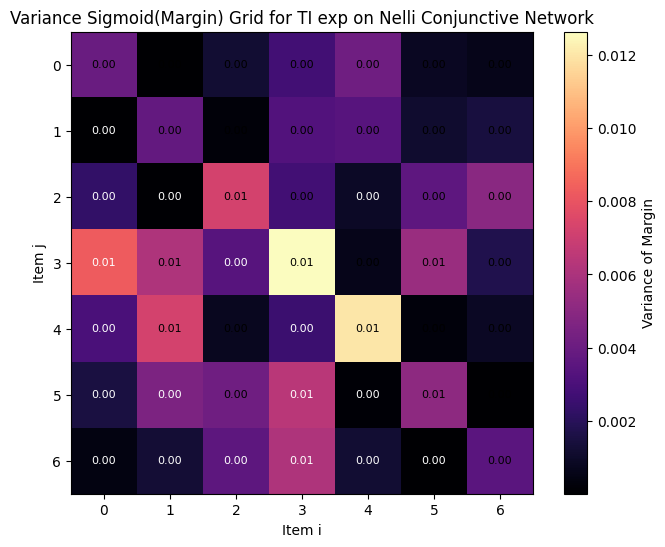

In [ ]:
n = items_n
Grid = np.zeros((seeds_n, n, n))
for seed in range(seeds_n):
    for i in range(n):
        for j in range(n):
            Grid[seed, i, j] = training_progress[seed, 480, i, j]
Average_Grid = np.mean(Grid, axis=0)
# Apply sigmoid function to Average_Grid
Average_Grid = 1 / (1 + np.exp(-Average_Grid))
Std_Grid = np.var(Grid, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(Average_Grid, cmap='viridis', interpolation='none')
plt.colorbar(label='Mean Margin')
plt.title(f'Mean Sigmoid(Margin) Grid for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot mean numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Average_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(Std_Grid, cmap='magma', interpolation='none')
plt.colorbar(label='Variance of Margin')
plt.title('Variance Grid for TI exp on Nelli Conjunctive Network')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot variance numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Std_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()